## **Covid Diagnosis Using Chest X-Ray Data**
***Important***: Before starting this question, please copy the folder into your own Google Drive, which you can do by downloading and then uploading to your Drive, or by doing `File > Save a Copy in Drive`.

### Introduction
COVID-19 is severely impacting the health of countless people worldwide. A crucial step in controlling the disease has been early detection of infected patients, which can be achieved through radiography, according to prior literature that shows COVID-19 causes chest abnormalities noticeable in chest X-rays. With this in mind, you will build a model that learns chest abnormalities and predicts whether a patient has COVID-19 based on his/her chest X-ray. To do this, you will utilize transfer learning.

We begin by importing necessary packages for this model. You will need to import more packages along the way, so feel free to add to this list or import as you go.


In [ ]:
import cv2
import os
import numpy as np

###Data Collection
There is no substantially-sized, clinically verified, and publicly available COVID-19 dataset. However, a small composite dataset with X-Rays of COVID-19 positive patients recently became publicly available with [DeepCovid](https://github.com/shervinmin/DeepCovid), which compiled their data from:

[Covid-Chestxray-Dataset](https://github.com/ieee8023/covid-chestxray-dataset) for COVID-19 X-ray samples

[ChexPert Dataset](https://stanfordmlgroup.github.io/competitions/chexpert/) for Non-COVID samples

If you do not have Google Colab Pro, it is highly recommended that you invest in this resource if you haven't already; however, this is not required, as you will not use the entire data set, but instead work with a subset of the data that we have compressed for you. To access this data, which is in the midterm folder in your Drive, you must begin by connecting to your Drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Now that we have connected our Colab to our Drive, we can find the path to the data.zip file and unzip it with ZipFile.

In [ ]:
from zipfile import ZipFile

file_name = 'drive/My Drive/Midterm/dataset.zip'

with ZipFile(file_name, 'r') as zip:
  zip.extractall('drive/My Drive/Midterm/dataset')
  print("Data extracted!")

Data extracted!


In [ ]:
image = cv2.imread('drive/My Drive/Midterm/dataset/dataset/covid/000001-1.jpg')
image.shape

(768, 968, 3)

Next, let us begin feature and label building. We can utilize Paths to 
list the directory of every X-Ray from the dataset.

In [ ]:
from imutils import paths

data = []
labels = []

#TODO: Grab list of image paths using paths.list_images
imagePaths = sorted(list(paths.list_images("drive/My Drive/Midterm/dataset/dataset/")))

In [ ]:
#TODO: Create a list of labels and image data by looping over the image paths
#Hint: You can extract the class label based on the image's filepath
#NOTE: Before adding the image to your list of images, you should do some preprocessing
#      Think about what the input of ResNet is; specifically, think about color 
#      channels and resizing (use cv2!).

for imagePath in imagePaths:
	# extract the class label from the filename
  label = imagePath.split("/")[-2]

  image = cv2.imread(imagePath)
  image = cv2.resize(image, (224, 224))
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


  data.append(image)
  labels.append(label)

In [ ]:
s = 'drive/My Drive/Midterm/dataset/dataset/covid/aspiration-pneumonia-5-day0.jpg'
s.split("/")[-2]

'covid'

Yikes, we're using a Python list to hold our data. Let's convert that to a Numpy Array and normalize the pixel values.

In [ ]:
data = np.array(data) / 255.0
labels = np.array(labels)

Our labels still need a little help. Let's use SKLearn to one-hot encode our labels.

In [ ]:
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical

lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

### Data Splitting
Now that we're done grabbing our data, we can begin to look at splitting the data into our training and validation sets.

In [ ]:
from sklearn.model_selection import train_test_split
#TODO: Partition data into 85% training and 15% validation

(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.15, random_state=42)

### Set hyperparameters
Before building the model, it's always important to set your relevant hyperparameters.

In [ ]:
EPOCHS = 20
BATCH_SIZE = 16
LR = 1e-4

### Base model
Let's load our ResNet model. Our pretrained weights should come from imagenet, and our input is (224,224,3) as mentioned earlier. Make sure to not include the fully-connected layers of the model as we are dealing with different output dimensions!

In [ ]:
#TODO: load in Resnet
# from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input

input_ = Input(shape=(224, 224, 3))
base = ResNet50(include_top = False, 
                weights='imagenet',
                input_tensor = input_)

base.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

###Head Architecture###
What we have now is a ResNet base model without any output layers. Thus, we must construct this part of the model, which will be placed on top of the base model. The architecture of this is completely up to you! Be cognizant of the activation functions you use and the order of your layers.

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LeakyReLU

#TODO: complete architecture of your model
#Hint: think about the output dimension.

head = base.output
head = Flatten()(head)
head = Dense(512, activation='relu')(head)
head = BatchNormalization()(head)
head = Dropout(0.2)(head)
head = Dense(256, kernel_regularizer=tf.keras.regularizers.l2(0.01))(head)
head = LeakyReLU(alpha=0.05)(head)
head = BatchNormalization()(head)
head = Dense(2, activation='softmax')(head)   

Now that we have the base model and the head model, we can combine them into one model. This model will be the model we use to train.

In [ ]:
from tensorflow.keras.models import Model

model = Model(inputs=base.input, outputs=head)

###Freeze Base Layers###
We want to ensure that our pretrained ResNet weights from imagenet are not changed during training. Thus, we can freeze those weights specifically.

In [ ]:
#TODO: freeze base model weights
for layer in base.layers:
  layer.trainable = False

Let's now compile the model. Choose a loss function that you think would work best for this task, as well as an appropriate optimizer. The metric you should specify is accuracy.

In [ ]:
from tensorflow.keras.optimizers import Adam
#TODO: compile model
model.compile(optimizer = Adam(lr=LR), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

### Data augmentation
The last thing we need to do before we can start training our model is to initialize our augmentation object for our training set, which will make our model more robust. Specify your desired rotation range and fill mode using ImageDataGenerator from Keras.

In [ ]:
#TODO: define ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator

trainAug = ImageDataGenerator(rotation_range = 40,
                              width_shift_range = 0.2,
                              height_shift_range = 0.2,
                              zoom_range = 0.2,
                              fill_mode="nearest")

###Training
We can now train the model. Because we are utilizing Keras's ImageDataGenerator, use model.fit_generator as opposed to model.fit.

If training is taking a while, check to make sure your runtime type is set to "GPU", which can be found in the toolbar: 

Runtime -> Change runtime type -> Hardware Accelerator: GPU.

In [ ]:
#TODO: train model

callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", 
                                 patience=8, 
                                 verbose=0, 
                                 mode="auto", 
                                 restore_best_weights=True,)

H = model.fit(trainAug.flow(trainX, trainY, batch_size=BATCH_SIZE),
              steps_per_epoch=len(trainX)//BATCH_SIZE,
              validation_data = (testX, testY),
              validation_steps = 20,
              epochs = EPOCHS,
              callbacks=[callback],
              verbose = 2)

Epoch 1/20
109/109 - 57s - loss: 3.5367 - accuracy: 0.8183 - val_loss: 3.6135 - val_accuracy: 0.7581
Epoch 2/20
109/109 - 19s - loss: 2.9003 - accuracy: 0.8545 - val_loss: 3.4180 - val_accuracy: 0.5903
Epoch 3/20
109/109 - 19s - loss: 2.4391 - accuracy: 0.8626 - val_loss: 3.5876 - val_accuracy: 0.5839
Epoch 4/20
109/109 - 19s - loss: 2.0987 - accuracy: 0.8534 - val_loss: 2.0315 - val_accuracy: 0.8516
Epoch 5/20
109/109 - 19s - loss: 1.8283 - accuracy: 0.8643 - val_loss: 1.7340 - val_accuracy: 0.9290
Epoch 6/20
109/109 - 19s - loss: 1.6041 - accuracy: 0.8729 - val_loss: 1.5500 - val_accuracy: 0.9194
Epoch 7/20
109/109 - 19s - loss: 1.4164 - accuracy: 0.8787 - val_loss: 2.9403 - val_accuracy: 0.5806
Epoch 8/20
109/109 - 19s - loss: 1.2822 - accuracy: 0.8844 - val_loss: 1.9518 - val_accuracy: 0.5323
Epoch 9/20
109/109 - 20s - loss: 1.1407 - accuracy: 0.8959 - val_loss: 1.5215 - val_accuracy: 0.6935
Epoch 10/20
109/109 - 19s - loss: 1.0609 - accuracy: 0.8896 - val_loss: 1.1822 - val_accura

### Predictions
Congrats! You've trained the model. Now let's look at some important metrics to see how well your model performs on the test set.

In [ ]:
from sklearn.metrics import classification_report

predIdxs = np.argmax(model.predict(testX, batch_size=BATCH_SIZE), axis=1)

print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

              precision    recall  f1-score   support

       covid       0.95      0.93      0.94       136
      normal       0.95      0.97      0.96       174

    accuracy                           0.95       310
   macro avg       0.95      0.95      0.95       310
weighted avg       0.95      0.95      0.95       310



We can also compute the confusion matrix to find the sensitivity and specificity.

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(testY.argmax(axis=1), predIdxs)
print(cm)

#TODO: compute sensitivity and specificity from confusion matrix
tn, fp, fn, tp = cm.ravel()
sensitivity = tp/(fn+tp)
specificity = tn/(fp+tn)
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

[[127   9]
 [  6 168]]
sensitivity: 0.9655
specificity: 0.9338


### Visualization
Let's plot your loss and accuracy metrics.

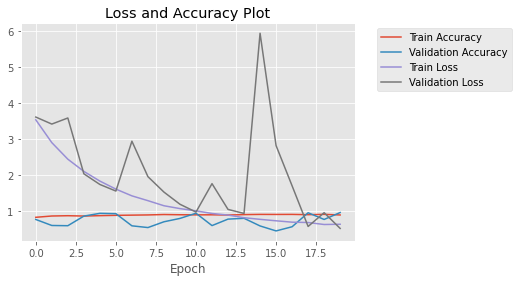

In [ ]:
import matplotlib.pyplot as plt


N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["accuracy"], label="Train Accuracy")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="Validation Accuracy")
plt.plot(np.arange(0, N), H.history["loss"], label="Train Loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="Validation Loss")
plt.title("Loss and Accuracy Plot")
plt.xlabel("Epoch")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.savefig("midterm_plot.png")

###Performance

Your final hand-in accuracy should be at least 0.75. If it is currently not, try modifying your head architecture. You will also add some additional regularization methods in the conceptual questions below which may help.

##Conceptual Questions

Please answer these questions in the context of this mini-project. For example, there is no issue with the data at all. :-)


1.

The base ResNet architecture includes batch normalization, so please also include this in your head model.

a. It is a common practice to freeze the batch norm parameters when fine-tuning. Why is this?


2.

Imagine you plot your training and validation losses per epoch and notice that while your training loss converges to 0.05 at epoch 40, your validation loss hits its minimum at 0.09 at epoch 20 and then steadily climbs up and up to 0.25 at epoch 30.

a. Explain why this is occuring.

b. Describe what you should set your epoch hyperparameter to in this situation and why. 

c. Explain three separate techniques on how to combat this phenomenon.

d. Implement one of these techniques in your current model (exluding data augmentation as this is already done).

*Solutions*


1)
Because the original model is trained on imagenet, which is a totally different distribution comparing to our dataset. It would not only take a long time for the network to learn $\gamma$ and $\beta$ in each batch normalization layer of the original architecture if it was not frozen, but also it was trained on a large dataset and would help our classification model, since our dataset of X-ray pictures is small and not enough to capture enough variances of the underlying distribution.


2)

a. The model started to overfit on the training data after 20 epochs.

b. Set epoch to 20, so that the training would stop before overfitting. Epoch 20 gives the lowest validation loss.

c. 
1. Add batch normalization layers to recenter the inputs to prevent too much diverging;
2. Augment the training data so that it captures more variances of the underlying distribution, which may occur in the validation set that are not in our current training set;
3. Add an early stopping callback which monitors the validation loss, so that it can stop the training automatically when it hits the lowest val_loss.

d. Done.

